<a href="https://colab.research.google.com/github/hmaldonado12/7506R-1C2024-GRUPO6/blob/main/tp2/TP2_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports y carga de archivos

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import seaborn as sns
import xgboost as xgb
import string
import nltk
import re

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [3]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv')
train_df.head()

,ID,review_es,sentimiento
0,0,Uno de los otros críticos ha mencionado que de...,positivo
1,1,Una pequeña pequeña producción.La técnica de f...,positivo
2,2,Pensé que esta era una manera maravillosa de p...,positivo
3,3,"Básicamente, hay una familia donde un niño peq...",negativo
4,4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo


In [5]:
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.csv')
test_df.head()

,ID,review_es
0,60000,La mayor virtud de esta película es su existen...
1,60001,"No soy un experto cinéfilo, pero pocas veces m..."
2,60002,Si no eres un incondicional del humor estilo T...
3,60003,"No sé qué está pasando, si la gente se deja ll..."
4,60004,"Pero cuando amanece,y me quedo solo,siento en ..."


In [6]:
train_df["sentimiento"].value_counts()

sentimiento
positivo    25000
negativo    25000
Name: count, dtype: int64

## DEBUG: Parámetros del output

In [7]:
# ----- PARAMETROS DEL OUTPUT -----
# MAX_ROWS: cantidad limite a mostrar, si se excede se resume (...)
# MIN_ROWS: cantidad de filas a mostrar pasado el corte
# MAX_COLWIDTH: ancho de columnas por cada output, si se excede se resume(...)

pd.reset_option("display.min_rows")
pd.reset_option("display.max_colwidth")
# pd.options.display.min_rows = 100000
# pd.options.display.max_colwidth = 1000

# Preprocesamiento de datos

Se deben limpiar y preprocesar cada uno de los textos para que los modelos puedan manejarlos adecuadamente. Esto incluye las consideraciones para caracteres especiales y la tokenización.

In [8]:
# Creo copias del dataset para procesar
token_train_df = train_df.copy()
#token_test_df = test_df.copy()

def preprocess_text(text):
    # Llevo texto a minúsculas
    text = text.lower()

    # Expresión regular para eliminar caracteres '¿', '¡', y '`'
    text = re.sub(r'[¡¿\`\']', ' ', text)

    # Expresión regular para separar palabras con puntos intermedios
    text = re.sub(r'([\wáéíóúü]+)\.+([\wáéíóúü]+)', r'\1 \2', text)

    # Tokenizacion
    tokens = word_tokenize(text, language='spanish')

    # Elimino signos de puntuación y números
    tokens = [word for word in tokens if word.isalpha()]

    return " ".join(tokens)

token_train_df['review_es'] = train_df['review_es'].apply(preprocess_text)
#token_test_df['review_es'] = test_df['review_es'].apply(preprocess_text)

In [9]:
token_train_df.head()

,ID,review_es,sentimiento
0,0,uno de los otros críticos ha mencionado que de...,positivo
1,1,una pequeña pequeña producción la técnica de f...,positivo
2,2,pensé que esta era una manera maravillosa de p...,positivo
3,3,básicamente hay una familia donde un niño pequ...,negativo
4,4,el amor en el tiempo de petter mattei es una p...,positivo


## Definición de Stop Words

In [10]:
# Cargo las stopwords del corpus de NLTK
stoplist = stopwords.words('spanish')
stoplist_eng = stopwords.words('english')

# Tokenizo el stoplist con el mismo tokenizador del corpus principal
stoplist_tokenized = []
for w in (stoplist + stoplist_eng):
    stoplist_tokenized = stoplist_tokenized + word_tokenize(w)

# Armo una lista sin repeticiones
stoplist_tokenized = list(set(stoplist_tokenized))

## Entrenamiento de Bag of Words

Se utiliza este método para convertir el texto en vectores numéricos que puedan ser utilizados por los modelos de machine learning.

Cómo parámetro del CountVectorizer, puede indicarse la cantidad de tokens a incluir para formar n-gramas.

In [11]:
# Instanciamos un CountVectorizer con una tupla indicando el rango de los n-gramas a considerar
vectorizer = CountVectorizer(ngram_range=(1,2), min_df=20, stop_words=stoplist_tokenized)

# Usamos .fit_transform() para ajustar el CV y transformar los datos
X_train = vectorizer.fit_transform(token_train_df['review_es'])
y_train = token_train_df['sentimiento']

En función de los tokens (y n-gramas) considerados, se pueden obtener distintas representaciones de la frecuencia de las palabras, para tener una idea de si son términos que aportan información relevante para clasificar una reseña.

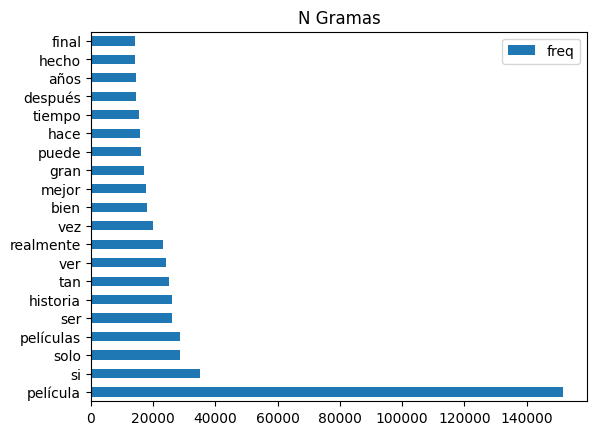

In [12]:
# Grafico frecuencias de términos de mayor a menor
import matplotlib.pyplot as plt
pd.DataFrame(X_train.sum(axis=0).T,
            index=vectorizer.get_feature_names_out(),
            columns=['freq']).sort_values(by='freq',
                                          ascending=False)[:20].plot(kind='barh',title='N Gramas');

In [13]:
# Muestro parte del vocabulario proporcionado
vocab = vectorizer.vocabulary_
vocab

{'críticos': 7922,
 'mencionado': 21852,
 'después': 9659,
 'ver': 37392,
 'solo': 33666,
 'oz': 24659,
 'episodio': 12261,
 'enganchado': 11932,
 'razón': 29898,
 'exactamente': 13238,
 'sucedió': 34407,
 'conmigo': 6944,
 'primera': 28480,
 'cosa': 7482,
 'golpeó': 15263,
 'brutalidad': 4312,
 'escenas': 12445,
 'violencia': 38150,
 'encuentran': 11851,
 'derecha': 9250,
 'palabra': 24735,
 'confía': 6921,
 'espectáculo': 12744,
 'débiles': 11062,
 'corazón': 7353,
 'tímido': 36793,
 'extrae': 13553,
 'punzones': 29452,
 'respecto': 30927,
 'drogas': 10927,
 'sexo': 32659,
 'hardcore': 16352,
 'uso': 36956,
 'clásico': 6176,
 'llama': 20161,
 'apodo': 1977,
 'dado': 8425,
 'seguridad': 32214,
 'máximo': 23142,
 'oswald': 24622,
 'centra': 5582,
 'principalmente': 28574,
 'ciudad': 6035,
 'sección': 32074,
 'experimental': 13438,
 'prisión': 28600,
 'todas': 35887,
 'células': 8298,
 'frentes': 14572,
 'vidrio': 38028,
 'enfrentan': 11915,
 'hacia': 16251,
 'adentro': 736,
 'privacida

# XGBoost

In [14]:
# Divido nuevamente conjunto train para entrenamiento y cálculo de métricas
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2, random_state=42)

In [15]:
# Proceso la variable categórica
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_split)
y_val_encoded = label_encoder.transform(y_val_split)

# Construyo matrices de datos para un rendimiento más óptimo del modelo
dtrain = xgb.DMatrix(X_train_split, label=y_train_encoded)
dval = xgb.DMatrix(X_val_split, label=y_val_encoded)

El modelo cuenta con varias formas de proceder con su entrenamiento, cada una priorizando distintos aspectos.

El método cv de XGBoost permite evaluar el rendimiento para valores fijos de hiperparámetros, con tal de evaluar distintas configuraciones. Permite dividir el conjunto de datos y crear una cantidad finita de folds.

In [32]:
# Conjunto de parámetros (no rangos)
params = {'objective': 'binary:logistic',
          'eval_metric': 'auc',
          'learning_rate': 0.1,
          'max_depth': 10,
          'subsample': 0.8,
          'colsample_bytree': 0.8,
          'verbosity': 0}

In [34]:
# Calculo medias y desviaciones de cada fold del conjunto train
cv_results = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,  # Número máximo de iteraciones de boosting
    nfold=5,  # Número de folds
    stratified=True,
    metrics={'auc'},
    early_stopping_rounds=50,  # Parar temprano si no hay mejora
    seed=42
)

cv_results

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.762593,0.001800,0.733725,0.003974
1,0.795007,0.004116,0.766989,0.005510
2,0.817801,0.003731,0.786734,0.003758
3,0.825102,0.002219,0.795398,0.003614
4,0.832924,0.002566,0.802235,0.004012
...,...,...,...,...
495,0.998110,0.000033,0.939464,0.002073
496,0.998119,0.000033,0.939491,0.002087
497,0.998126,0.000032,0.939513,0.002068
498,0.998137,0.000030,0.939517,0.002085


In [38]:
# Entreno el modelo con los hiperparámetros y el conjunto train
model_cv = xgb.train(params, dtrain, num_boost_round=500, evals=[(dval, 'validation')], early_stopping_rounds=50, verbose_eval=False)

## Métricas

Para sacar las métricas del modelo obtenido, se realizarán predicciones sobre el subconjunto de validación del conjunto train.

In [48]:
# Realizo la predicción y fijo un umbral de 0.5 para clasificar
y_pred = model_cv.predict(dval)
y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]

In [49]:
# Recupero las variables categóricas
y_val_pred_labels = label_encoder.inverse_transform(y_pred_binary)
y_val_true_labels = label_encoder.inverse_transform(y_val_encoded)

# Imprimir métricas de evaluación
print("Accuracy:", accuracy_score(y_val_true_labels, y_val_pred_labels))
print("Precision:", precision_score(y_val_true_labels, y_val_pred_labels, pos_label='positivo'))
print("Recall:", recall_score(y_val_true_labels, y_val_pred_labels, pos_label='positivo'))
print("F1 Score:", f1_score(y_val_true_labels, y_val_pred_labels, pos_label='positivo'))
print('AUC:', roc_auc_score(y_val_encoded, y_pred_binary))

print("Classification Report:\n", classification_report(y_val_true_labels, y_val_pred_labels))


Accuracy: 0.8669
Precision: 0.8596353656145854
Recall: 0.877
F1 Score: 0.8682308682308683
AUC: 0.8669
Classification Report:
               precision    recall  f1-score   support

    negativo       0.87      0.86      0.87      5000
    positivo       0.86      0.88      0.87      5000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



Text(50.722222222222214, 0.5, 'True')

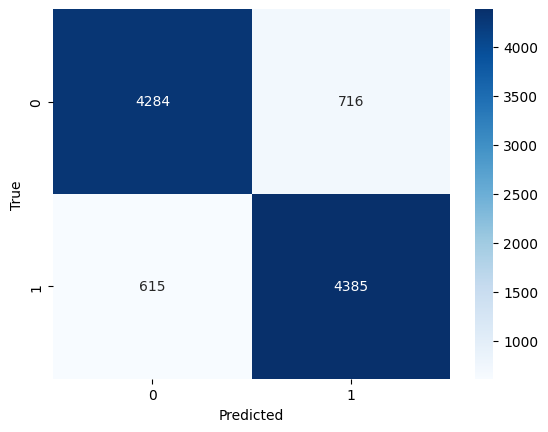

In [50]:
#Matriz de Confusion
cm = confusion_matrix(y_val_true_labels, y_val_pred_labels)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

# Predicción sobre conjunto Test

Se repite todo el tratamiento de los textos en el conjunto Test para llegar a la predicción final.

In [51]:
# Tokenización
token_test_df = test_df.copy()
token_test_df['review_es'] = test_df['review_es'].apply(preprocess_text)

In [52]:
token_test_df.head()

,ID,review_es
0,60000,la mayor virtud de esta película es su existen...
1,60001,no soy un experto cinéfilo pero pocas veces me...
2,60002,si no eres un incondicional del humor estilo t...
3,60003,no sé qué está pasando si la gente se deja lle...
4,60004,pero cuando amanece y me quedo solo siento en ...


In [53]:
# Bag of Words + XGBoost
X_test = vectorizer.transform(token_test_df['review_es'])
dtest = xgb.DMatrix(X_test)
test_predictions = model_cv.predict(dtest)

In [54]:
# Recupero variables categóricas
test_predictions_labels = label_encoder.inverse_transform([1 if pred > 0.5 else 0 for pred in test_predictions])

## Exportar CSV para Submission

In [55]:
# Creo nuevo DF con ID de reseña y predicción de sentimiento
output_df = pd.DataFrame({'ID': test_df['ID'], 'sentimiento': test_predictions_labels})
output_df

,ID,sentimiento
0,60000,negativo
1,60001,positivo
2,60002,negativo
3,60003,negativo
4,60004,negativo
...,...,...
8594,68594,positivo
8595,68595,negativo
8596,68596,positivo
8597,68597,negativo


In [56]:
# Genero archivo CSV
output_df.to_csv('/content/drive/My Drive/Colab Notebooks/XGBoost-V8.csv', index=False)